#### Import packages and field data

In [1]:
from initialisation import *

# Import empirical vegetation density
Vs_matrix = {landscape: np.loadtxt('field-data/'+landscape+'/vegetation.asc', skiprows=6)[1:-1,1:-1]/100 for landscape in ['shrubland', 'grassland']}
Vs = {landscape: matrix_to_dict(Vs_matrix[landscape]) for landscape in ['shrubland', 'grassland']}

# Import empirical topography
Ts_matrix = {landscape: np.loadtxt('field-data/'+landscape+'/topography.asc', skiprows=6)[1:-1,1:-1] for landscape in ['shrubland', 'grassland']}
Ts = {landscape: matrix_to_dict(Ts_matrix[landscape]) for landscape in ['shrubland', 'grassland']}

# Create baseline 2D lattice, empirical field data default width=20 and height=60
G, bulk_nodes = generate_baseline_lattice(20,60)


#### Linear regression between empirical vegetation density score and landscape microtopography

In [28]:
veg_scores, X, Y, alpha, beta, alpha_std, Y_line, MTs = {}, {}, {}, {}, {}, {}, {}, {}
for landscape in ['grassland', 'shrubland']:
    # Compute vegetation density scores and microtopography on empirical shrubland
    veg_scores[landscape] = compute_landscape_vegetation_score(Vs_matrix[landscape])
    MTs[landscape] = Ts_matrix[landscape] - np.array(list(np.mean(Ts_matrix[landscape], axis=1) for k in range(20))).T
    
    # Linear regression between X (scores) and Y (microtopography) to obtain a slope alpha, an intercept beta and a slope standard deviation alpha_std.
    alpha[landscape], beta[landscape] = np.polyfit(veg_scores[landscape].flatten(), MTs[landscape].flatten(), 1)
    Y_line[landscape] = [i*alpha[landscape]+beta[landscape] for i in veg_scores[landscape].flatten()]
    alpha_std[landscape] = np.std([MTs[landscape].flatten()[k]-Y_line[landscape][k] for k in range(len(G))])


#### Visualisation

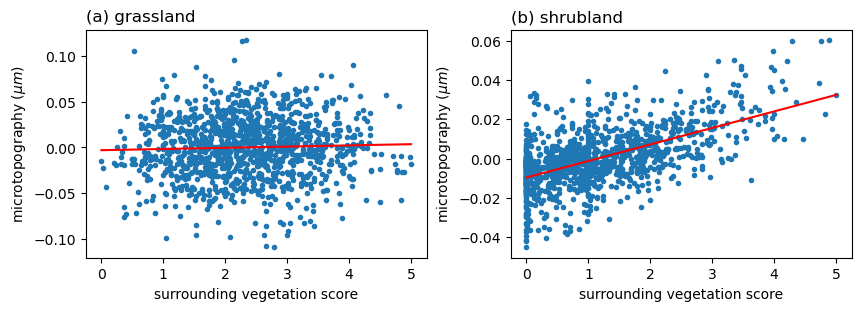

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(8.5,3), constrained_layout=True)
ax[0].scatter(veg_scores['grassland'].flatten(), MTs['grassland'].flatten(), marker='.')
ax[0].plot([0, 5], [beta['grassland'], alpha['grassland']*5 + beta['grassland']], c='red')
ax[0].set_xlabel('surrounding vegetation score')
ax[0].set_ylabel('microtopography ($\\mu m$)')
ax[0].set_title('(a) grassland', loc='left')
ax[1].scatter(veg_scores['shrubland'].flatten(), MTs['shrubland'].flatten(), marker='.')
ax[1].plot([0, 5], [beta['shrubland'], alpha['shrubland']*5 + beta['shrubland']], c='red')
ax[1].set_xlabel('surrounding vegetation score')
ax[1].set_ylabel('microtopography ($\\mu m$)')
ax[1].set_title('(b) shrubland', loc='left')
plt.show()


#### Landscape generation

In [60]:
np.array(list(np.mean(Ts_matrix[landscape], axis=1) for k in range(20))).T


array([[1.00775, 1.00775, 1.00775, ..., 1.00775, 1.00775, 1.00775],
       [0.99705, 0.99705, 0.99705, ..., 0.99705, 0.99705, 0.99705],
       [0.9849 , 0.9849 , 0.9849 , ..., 0.9849 , 0.9849 , 0.9849 ],
       ...,
       [0.1911 , 0.1911 , 0.1911 , ..., 0.1911 , 0.1911 , 0.1911 ],
       [0.1799 , 0.1799 , 0.1799 , ..., 0.1799 , 0.1799 , 0.1799 ],
       [0.16515, 0.16515, 0.16515, ..., 0.16515, 0.16515, 0.16515]])

In [ ]:
# Select landscape type to generate
landscape = 'shrubland'

# Enter vegetation parameters
veg_cover, p_clustering = 0.3, 0.8

# Generate vegetation plot by sampling densities from the shrubland vegetation density distribution, for a cover veg_cover and clustering p_clustering
V = generate_vegetation(G, veg_cover, p_clustering, Vs[landscape])

# Generate topography from the generated shrubland plot V
T_matrix, MT_matrix = generate_topography(Ts_matrix[landscape], V, alpha[landscape], alpha_std[landscape], beta[landscape])


#### Visualisation of the generated landscape

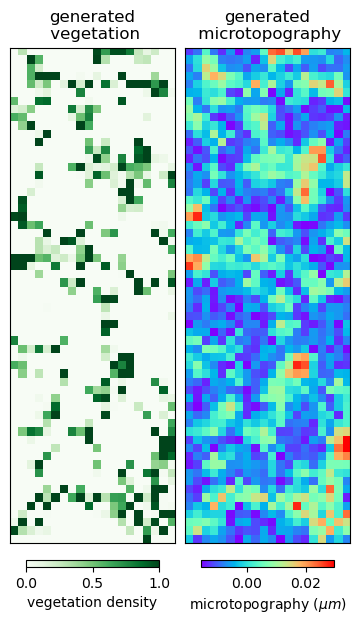

In [68]:
fig, ax = plt.subplots(1,2, figsize=(3.5,6), constrained_layout=True)
p = [ax[0].imshow(dict_to_mat(V), cmap='Greens'), ax[1].imshow(MT_matrix, cmap='rainbow')]
_ = [ax[k].set_xticks([]) for k in range(2)]
_ = [ax[k].set_yticks([]) for k in range(2)]
cbar = [fig.colorbar(p[k], ax=ax[k], orientation='horizontal', shrink=.8, pad=.03) for k in range(2)]
cbar[0].set_label('vegetation density')
cbar[1].set_label('microtopography ($\\mu m$)')
_ = ax[0].set_title('generated\n vegetation')
_ = ax[1].set_title('generated\n microtopography')
plt.show()
